# Naive Recursive Pascal Triangle

In this notebook, we explore the results of running a naive recursive algorithm for the Pascal triangle with exponential complexity in both python and scala.

The code used for both languages was equivalent. Each script was run sequentially for Pascal triangles of depth ranging from 0 to 32 with a redundancy of 5. 

For **python**:

```python
import sys

def pascal_triangle(level, line=0, print_flag=True):
    def elem(i, j):
        return 1 if (j >= i or j == 0) else elem(i-1, j-1) + elem(i-1, j)
    format_line = " ".join([str(elem(line, j)) for j in range(line+1)])
    if print_flag:
        print(format_line)
    if line < level:
        pascal_triangle(level, line+1, print_flag)

def main():
    levels = int(sys.argv[1])
    flag = "-print" in " ".join(sys.argv)
    if levels < 0:
        raise ValueError("Argument must be greater than zero.")
    pascal_triangle(levels, print_flag=flag)


if __name__ == "__main__":
    main()
```

For **scala**:
```scala

object PascalTriangle {

  def main(args: Array[String]): Unit = {
    val levels: Int = args(0).toInt
    val printFlag: Boolean = args mkString " " contains "-print"
    pascalTriangle(levels, 0, printFlag)
  }

  def pascalTriangle(level: Int, line: Int = 0, printFlag: Boolean = true): Unit = {
    def elem(i: Int, j: Int): Int = 
      if (j >= i || j == 0) 1 else elem(i-1, j-1) + elem(i-1, j)
    val formatLine: String = (0 to line) map {elem(line, _).toString} mkString " "
    if (printFlag) println(formatLine)
    if (line < level) pascalTriangle(level, line+1, printFlag)
  }

}

```

For **scala-futures**:
```scala
import scala.concurrent.{Await, Future}
import scala.concurrent.ExecutionContext.Implicits.global
import scala.concurrent.duration.Duration

object PascalTriangle {

  def main(args: Array[String]): Unit = {
    val levels: Int = args(0).toInt
    val printFlag: Boolean = args mkString " " contains "-print"
    val res = pascalTriangle(levels, 0, printFlag)
    Await.ready(res, Duration.Inf)
  }

  def pascalTriangle(level: Int, line: Int = 0, printFlag: Boolean): Future[Unit] = {
    def elem(i: Int, j: Int): Int =
      if (j >= i || j == 0) 1
      else elem(i-1, j-1) + elem(i-1, j)
    val formatLine: Future[String] = Future {(0 to line) map {elem(line, _).toString} mkString " "}
    val sideEffects: Future[Unit] = formatLine.map {v =>
      if (printFlag) println(v)
    }
    if (line < level) pascalTriangle(level, line+1, printFlag)
    else sideEffects
  }

}

```

## Load results

We are going to use pandas to manipulate the data with dataframes and seaborn / matplotlib for visualizations. 

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The raw data contained in *data/results.csv* is the execution time of the Pascal Triangle program for both python and scala code with redundancy of 5. We need to aggregate this results with an average for each depth for a reliable comparison. 

In [2]:
# Read data into a pandas dataframe

data = pd.read_csv("data/results.csv", header=None).rename(columns={
    0: "lang", 
    1: "method", 
    2: "depth", 
    3: "duration"
})

data.head()

,lang,method,depth,duration
0,scala,naive,0,3.761934
1,scala,naive,0,1.167530
2,scala,naive,0,0.875052
3,scala,naive,0,0.817027
4,scala,naive,0,0.827974


We can aggregate the data using the groupby method for the columns {lang, depth}. 

In [3]:
average_data = data.groupby(["lang", "depth"]).mean().reset_index()
average_data.head()

,lang,depth,duration
0,python,0,0.075371
1,python,1,0.012920
2,python,2,0.011636
3,python,3,0.011465
4,python,4,0.012607


Now each row in the dataframe represents the average time of execution for a given depth in python or scala.

## Execution Time

We begin by plotting the execution time of the algorithms. 

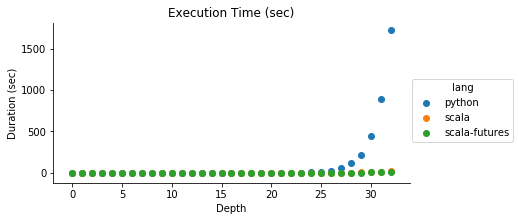

In [4]:
fg = sns.FacetGrid(data=average_data, hue='lang', aspect=2)
fg.map(plt.scatter, 'depth', 'duration').add_legend()

plt.title("Execution Time (sec)")
plt.ylabel("Duration (sec)")
plt.xlabel("Depth")
plt.show()
plt.close()

The algorithm was implemented with an exponential complexity. We can see that the python code increases more "quickly" than the scala implementation.

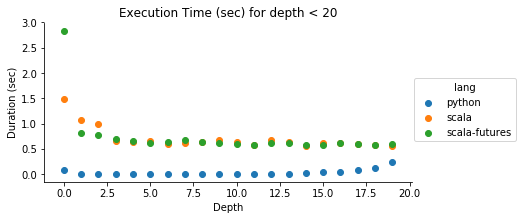

In [5]:
fg = sns.FacetGrid(data=average_data.query("depth < 20"), hue='lang', aspect=2)
fg.map(plt.scatter, 'depth', 'duration').add_legend()

plt.title("Execution Time (sec) for depth < 20")
plt.ylabel("Duration (sec)")
plt.xlabel("Depth")
plt.show()
plt.close()

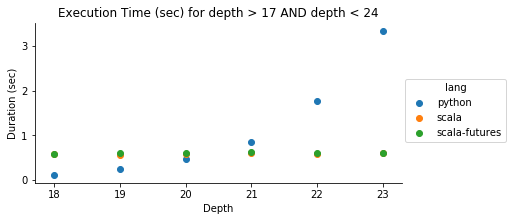

In [6]:
fg = sns.FacetGrid(data=average_data.query("depth > 17 and depth < 24"), hue='lang', aspect=2)
fg.map(plt.scatter, 'depth', 'duration').add_legend()

plt.title("Execution Time (sec) for depth > 17 AND depth < 24")
plt.ylabel("Duration (sec)")
plt.xlabel("Depth")
plt.show()
plt.close()

Nonetheless, at lower depth levels, the python implementation runs faster. 

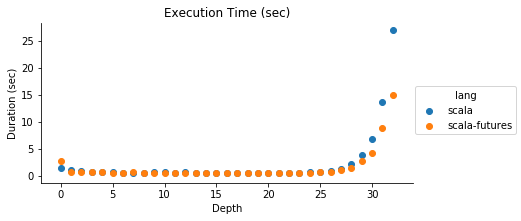

In [8]:
fg = sns.FacetGrid(data=average_data.query("lang != 'python'"), hue='lang', aspect=2)
fg.map(plt.scatter, 'depth', 'duration').add_legend()

plt.title("Execution Time (sec)")
plt.ylabel("Duration (sec)")
plt.xlabel("Depth")
plt.show()
plt.close()

If we filter out the python results, we can see the visual comparison between scala and scala-futures implementation.

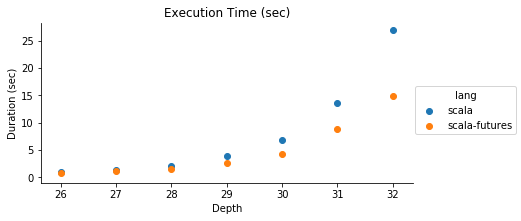

In [12]:
fg = sns.FacetGrid(data=average_data.query("lang != 'python' and depth > 25"), hue='lang', aspect=2)
fg.map(plt.scatter, 'depth', 'duration').add_legend()

plt.title("Execution Time (sec)")
plt.ylabel("Duration (sec)")
plt.xlabel("Depth")
plt.show()
plt.close()

As expected, the scala-futures implementation scales better. Nonetheless, it's depenedent on the number of available cores of the machine for the computation. 

## Stats

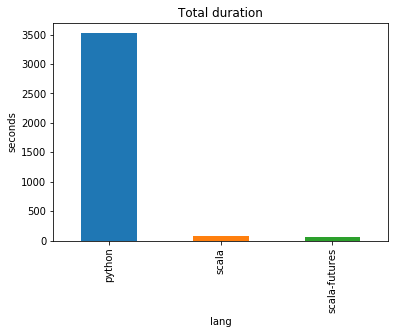

Python is 47.99 times slower than Scala.
Python is 66.63 times slower than Scala Futures.
Scala is 1.39 times slower than Scala Futures.


In [16]:
total_duration = average_data.groupby("lang").duration.sum()

total_duration.plot.bar()
plt.title("Total duration")
plt.ylabel("seconds")
plt.show()

pysc_ratio = total_duration["python"] / total_duration["scala"]
pysf_ratio = total_duration["python"] / total_duration["scala-futures"]
scsf_ratio = total_duration["scala"] / total_duration["scala-futures"]
print("Python is %0.2f times " % pysc_ratio + ("slower" if pysc_ratio > 1 else "faster") + " than Scala.")
print("Python is %0.2f times " % pysf_ratio + ("slower" if pysf_ratio > 1 else "faster") + " than Scala Futures.")
print("Scala is %0.2f times " % scsf_ratio + ("slower" if scsf_ratio > 1 else "faster") + " than Scala Futures.")

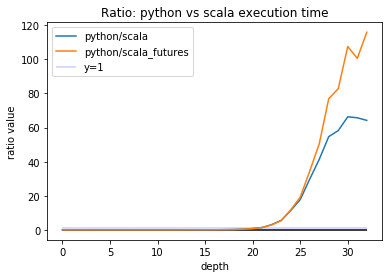

In [23]:
python_data = average_data.query("lang == 'python'").sort_values("depth").reset_index(drop=True)
scala_data = average_data.query("lang == 'scala'").sort_values("depth").reset_index(drop=True)
scalaf_data = average_data.query("lang == 'scala-futures'").sort_values("depth").reset_index(drop=True)

ratios = pd.DataFrame([])
ratios["python/scala"] = (python_data.duration / scala_data.duration).values
ratios["python/scala_futures"] = (python_data.duration / scalaf_data.duration).values
ratios["scala/scala_futures"] = (scala_data.duration / scalaf_data.duration).values
pysc_ratio = (python_data.duration / scala_data.duration).to_frame().rename(columns={"duration": "python/scala"})

ratios[["python/scala","python/scala_futures"]].plot()
plt.title("Ratio: python vs scala execution time")
plt.ylabel("ratio value")
plt.xlabel("depth")

plt.hlines(y=0, xmin=0, xmax=32)
plt.hlines(y=1, xmin=0, xmax=32, label="y=1",color="blue", alpha=0.2)

plt.legend()
plt.show()

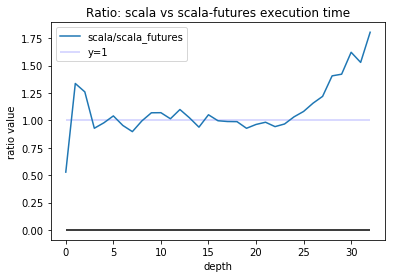

In [25]:
ratios[["scala/scala_futures"]].plot()
plt.title("Ratio: scala vs scala-futures execution time")
plt.ylabel("ratio value")
plt.xlabel("depth")

plt.hlines(y=0, xmin=0, xmax=32)
plt.hlines(y=1, xmin=0, xmax=32, label="y=1",color="blue", alpha=0.2)

plt.legend()
plt.show()